# Solar mask model
This notebook demonstrates how to use the solar mask model


In [2]:
from buildingmodel import data_path
from buildingmodel.main import Parameters, load_data, run_inference, run_creation
from buildingmodel.io.gis import load_data as load_gis_data
from buildingmodel.io.climate import load_data as load_climate_data
from buildingmodel.models.climate import run_models as run_climate_models
from buildingmodel.creation.boundary import run_creation as run_boundary_creation
from buildingmodel.models.solar_masks import run_models as run_solar_mask_models
from buildingmodel.models.solar_gains import run_models as run_solar_gain_models
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

Loading gis data and running the boundary creation model are required before running the solar mask model (the masks are calculated at the center of each exterior wall and roof)

In [3]:
parameters = Parameters(
    districts="districts_test_sample.gpkg",
    district_level_census="district_level_census_test_sample.hdf",
    district_level_diagnosis="district_level_diagnosis_data_test_sample.hdf",
    gas_network_route="gas_network_route_sample.gpkg",
    simplification_tolerance=0.1,
)

building_data = Path(data_path["gis"]) / "testing" / "test_sample.gpkg"
climate_data = Path(data_path["climate"]) / "Brest.epw"

buildings, climate, metadata = load_data(building_data, climate_data, parameters)
buildings, boundaries, dwellings = run_creation(buildings, parameters)
dwellings, buildings = run_inference(buildings, dwellings, boundaries, parameters)
run_climate_models(climate, metadata, parameters)

/home/yassine/miniconda3/envs/buildingmodel_dev/lib/python3.8/site-packages/topojson/core/cut.py:112: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_splitter = STRtree(mp)


The mask model takes as input the building and boundary GeoDataframes, as well as optional parameters grid_resolution (in meters) and angular_resolution (in degrees)

In [6]:
parameters.grid_resolution = 0.2
parameters.angular_resolution = 10.0
parameters.bbox_filter = 100.0

boundaries = run_solar_mask_models(buildings, boundaries, parameters)

The results of the mask model are concatenated to the boundary GeoDataframe passed as input. The number of columns containing mask results depends on the angular resolution.

In [7]:
mask_columns = [
    col_name for col_name in boundaries.columns if col_name.startswith("mask_")
]

In [8]:
boundaries[mask_columns].head(10)

mask_0     mask_1     mask_2     mask_3     mask_4     mask_5     mask_6  \
0      0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
2     90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
3     90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
4     90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
5     90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
6     90.0  90.000000   0.000000   0.000000   0.000000   0.000000  89.330561   
36     0.0  10.607839  12.195332  13.307794  14.199923  14.601427  14.665498   
37    90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
38    90.0  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   

       mask_7     mask_8     mask_9  ...    mask_27    mask_28    mask_29  \
0    0.000000   0.000000   0.000000  ...  90.000000  90.000000  90.000000   
1   90.000000  90.000000  90.000000  ...   7.725851   7.884824   9.086201   
2   90.000000  90.000000  90.000000  ...  28.571591  11.547256   9.941625   
3   90.000000  90.000000  90.000000  ...  45.177657  50.875262  90.000000   
4   90.000000  90.000000  90.000000  ...  37.754538  34.215829  30.585186   
5   90.000000  90.000000  90.000000  ...   0.000000   0.000000  90.000000   
6   14.502335  14.015015  13.060362  ...  90.000000  90.000000  90.000000   
36  14.578485  13.989155  13.228434  ...  90.000000  90.000000  90.000000   
37  90.000000  90.000000  90.000000  ...   9.772777   8.805085   7.559253   
38  90.000000  90.000000  90.000000  ...   1.943871   7.511871  90.000000   

      mask_30    mask_31    mask_32    mask_33    mask_34    mask_35  mask_36  
0   19.655833  20.737675  21.306570  85.532880   0.000000   0.000000      0.0  
1   10.014632  10.645363  10.931181  10.964663  14.798831  22.270093      0.0  
2    9.764441  10.362783  10.653227  10.679292  10.616735  10.262963      0.0  
3   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000     90.0  
4   25.044680  18.883746  13.159557  13.197851  13.121730  12.668176      0.0  
5   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000     90.0  
6   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000     90.0  
36  13.717217  14.618307  14.993473  82.732568   0.000000   0.000000      0.0  
37   6.932708   7.345726   7.537268   7.552021   7.488912   7.221574      0.0  
38  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000     90.0  

[10 rows x 37 columns]

The following function will plot side by side the geometries of the buildings as well as the mask for the i-th boundary

In [19]:
def plot_mask(buildings, boundaries, i):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 7))

    buildings.plot(ax=ax[0], color="red", alpha=0.5)
    gpd.GeoDataFrame(geometry=[boundaries.iloc[i].geometry]).plot(
        ax=ax[0], color="blue"
    )
    mask_columns = [
        col_name for col_name in boundaries.columns if col_name.startswith("mask_")
    ]
    boundaries[mask_columns].iloc[i].transpose().plot(ax=ax[1])
    plt.show()

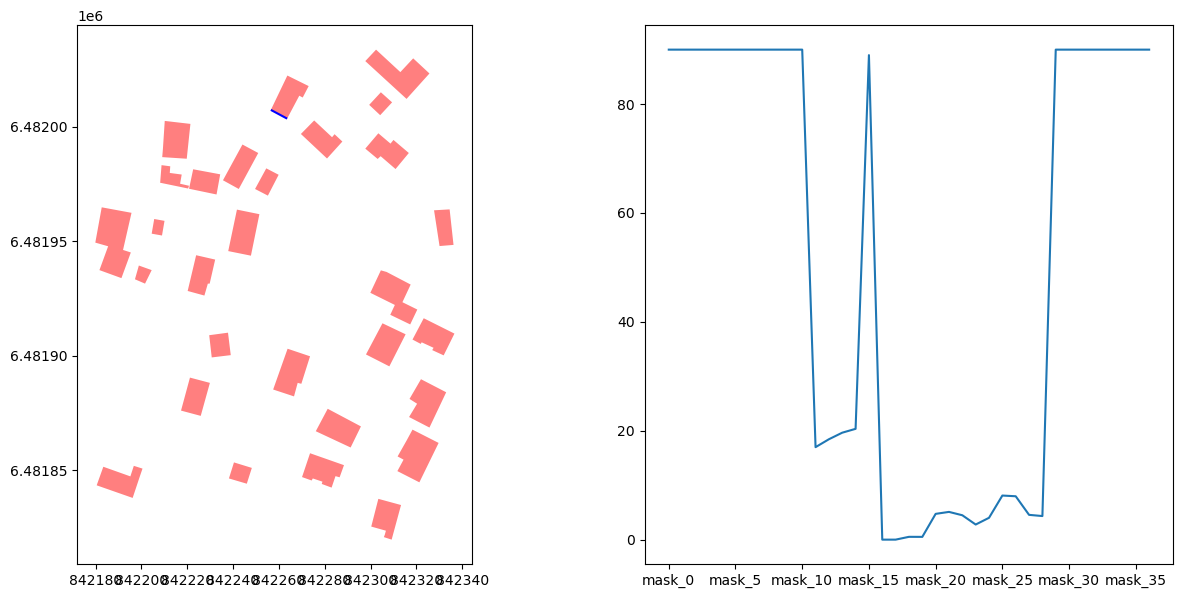

In [26]:
plot_mask(buildings, boundaries, 52)

The following code will import a 3d plotting utility that relies on additional dependencies mapbox_earcut and k3d. Make sure to install them before executing the next cells.

In [8]:
from buildingmodel.io.plot_3D import plot_3D_district

In [9]:
boundaries["average_mask"] = boundaries[mask_columns].mean(axis=1)

plot_3D_district(buildings, boundaries, "average_mask", [0.0, 90.0])

/home/yassine/miniconda3/envs/buildingmodel/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/yassine/miniconda3/envs/buildingmodel/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…